https://towardsdatascience.com/predict-the-number-of-likes-on-instagram-a7ec5c020203

# Imports

In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

from lib.utils import clean_sentence, clean_text
from lib.preprocess import calc_duration, transform_to_year, aggregate_transactions

In [2]:
import pandas as pd
import json
import numpy as np
import re
import pickle
from datetime import datetime
import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# import nltk
# import deeppavlov
import gensim
import gc
# from pymystem3 import Mystem
from gensim.models.wrappers import FastText

import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

# Data Loading

In [4]:
DATA_PATH = '../data_like/'

In [5]:
train = pd.read_csv(DATA_PATH+'customer_train.csv')
test = pd.read_csv(DATA_PATH+'customer_test.csv')

stories = pd.read_csv(DATA_PATH+'stories_description.csv')

train_y = pd.read_csv(DATA_PATH+'stories_reaction_train.csv')
test_y = pd.read_csv(DATA_PATH+'stories_reaction_test.csv')

transaction = pd.read_csv(DATA_PATH+'transactions.csv')

# Extracting text features from jsons

### !!!!Тема сториза!!!!1

In [6]:
REG_TEXT = "text\":\"(.*?)\","
REG_NAME = "name\":\"(.*?)\","
NUM_SWIPES = "description\":\"[0-9]{1,2}"

r = re.findall(REG_NAME, stories['story_json'][10])

In [7]:
decoded_stories = dict()
for i in stories.index:
    cur_story = stories['story_json'][i]
    story_info = dict()
    name = re.findall(REG_NAME, cur_story)
    story_info['name'] = "" if len(name) == 0 else clean_sentence(name[0])
    story_info['text'], story_info['n_words'] = clean_text(re.findall(REG_TEXT, cur_story))
    story_info['swipes'] = len(re.findall(NUM_SWIPES, cur_story))
    decoded_stories[stories['story_id'][i]] = story_info

In [44]:
CATEGORY = "text\":\"[А-ЯA-Z]+\""

In [53]:
cat = []
for i in stories.index:
    cur_story = stories['story_json'][i]
    if re.findall(CATEGORY, cur_story):
        cat.append(re.findall(CATEGORY, cur_story))  #[0][7:-1])

In [55]:
len(cat)

94

In [56]:
len(stories)

959

In [32]:
a = set()

In [33]:
for c in cat:
    a.add(c)

TypeError: unhashable type: 'list'

In [10]:
# with open("stories", "rb") as fp:
#     b = pickle.load(fp)

# Data Analysis 

## 1) Likes, Dislikes and other stuff

#### Customers can watch the same stories few times, can be a good feature

In [242]:
train_y.event.value_counts() / len(train_y)

view       0.512135
skip       0.354159
like       0.119810
dislike    0.013896
Name: event, dtype: float64

top_liked : top_disliked  ==  31 <br>
top_viewed : top_disliked  ==  22 <br>
top_skiped : top_disliked  ==  20 <br>
top_viewed : top_liked  == 29 <br>
top_skiped : top_liked == 24 <br>
top_viewed : top_skiped == 27 <br>

### ???? disliked are much more similar to liked, may be it is a misclick of user ?????

## 2) Users info

#### Let's watch by eyes to data

In [243]:
# categorial_feat = ['product_0', 'product_1', 'product_2', 'product_3', 
#                    'product_4', 'product_5', 'product_6', 'gender_cd',
#                    'marital_status_cd', 'children_cnt', 'job_position_cd', 'job_title']
# for col in categorial_feat:
#     print('FEATURE:', col)
#     print(train[col].value_counts())
#     print('Nans:', len(train) - np.sum(train[col].value_counts()))
#     print('_________')

#### Let's see data of registration

#### Let's see age

In [11]:
train.age = train.age.fillna(np.mean(train.age.dropna()))
np.unique(train.age)

array([15.        , 20.        , 25.        , 30.        , 33.90209298,
       35.        , 40.        , 45.        , 50.        , 55.        ,
       60.        , 65.        , 70.        , 75.        , 80.        ,
       85.        ])

### can use it as a categorial feature

## 3) Transactions

In [ ]:
# description.loc[transaction.columns].iloc[3: ]

#### There are a lot of popular shops, maybe like x5 

In [249]:
len(transaction.merchant_mcc.value_counts())

409

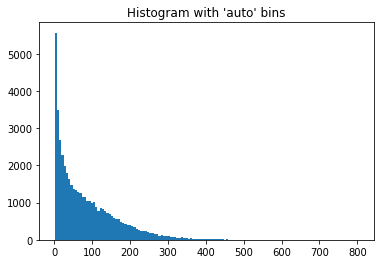

514522     804
588639     788
333041     768
588106     700
673392     690
          ... 
542958       1
462666       1
743422       1
1010076      1
195566       1
Name: customer_id, Length: 46948, dtype: int64

In [250]:
_ = plt.hist(transaction.customer_id.value_counts(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()
transaction.customer_id.value_counts()

#### Ideas: <br> 1. average amount of money for transaction for each user, two features: average over all transactions and of >0 rubles transactions<br> 2. average number of transaction per month <br> 3. Maybe if user visits top popular shops 

# -----------------------------

# Preprocessing

## 1) Customer_train/test

Порезаьть те вещи, которые я указал выше - done<br>
Посчитать число лет от текущего момента - done <br>
Переделать дату - done

In [11]:
train = pd.read_csv(DATA_PATH+'customer_train.csv')
test = pd.read_csv(DATA_PATH+'customer_test.csv')
print(train.shape)
print(test.shape)

(50000, 15)
(54245, 15)


#### Cutting very rare stuff

In [12]:
train.age = train.age.fillna(np.mean(train.age.dropna()))
test.age = test.age.fillna(np.mean(test.age.dropna()))

In [13]:
train.head()

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title
0,894436,NaN,NaN,NaN,NaN,NaN,UTL,NaN,M,30.0,MAR,0.0,2018-03-20 09:10:16,1,Неруководящий сотрудник - обсл. Персонал
1,524526,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,20.0,UNM,0.0,2017-03-29 20:38:45,16,NaN
2,498134,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,25.0,UNM,0.0,2018-03-12 11:25:06,22,NaN
3,278941,NaN,NaN,UTL,CLS,NaN,UTL,UTL,M,25.0,NaN,NaN,2016-02-21 18:47:51,16,Неруководящий сотрудник - специалист
4,877312,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,40.0,MAR,0.0,2018-03-07 11:17:02,22,NaN


In [14]:
test.head()

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title
0,234305,NaN,NaN,NaN,NaN,NaN,UTL,NaN,F,25.0,NaN,0.0,2015-10-29 09:59:10,22,Менеджер проектов
1,914339,NaN,NaN,NaN,NaN,NaN,UTL,NaN,M,15.0,NaN,0.0,2018-04-09 08:51:54,22,NaN
2,895631,NaN,NaN,NaN,NaN,NaN,UTL,NaN,M,20.0,NaN,0.0,2018-03-22 10:38:33,16,Менеджер по продажам
3,954837,NaN,NaN,NaN,NaN,NaN,UTL,NaN,F,25.0,NaN,0.0,2018-05-09 18:24:32,16,Инженер
4,391590,NaN,UTL,NaN,NaN,NaN,NaN,NaN,M,30.0,UNM,0.0,2016-10-08 05:29:20,20,сборщик мебели


In [15]:
nan = 'NAN'
train = train.fillna(nan)
test = test.fillna(nan)

In [16]:
# Delete rare jobs because it may be useless during one-hot encoding
train.job_title = [job.lower() if isinstance(job, type('aaa')) else job for job in train.job_title]
common_jobs = set(train['job_title'].value_counts().keys()[train['job_title'].value_counts() > 25])
train.job_title = [job if job in common_jobs else nan for job in train.job_title]

test.job_title = [job.lower() if isinstance(job, type('aaa')) else job for job in test.job_title]
common_jobs = set(test['job_title'].value_counts().keys()[test['job_title'].value_counts() > 25])
test.job_title = [job if job in common_jobs else nan for job in test.job_title]

In [17]:
# common_n_status = set(train['marital_status_cd'].value_counts().keys()[train['marital_status_cd'].value_counts() > 2])
# train.marital_status_cd = [ch if ch in common_n_status else nan for ch in train.marital_status_cd]

#### Calculating amount of time since regestration till now

In [18]:
calc_duration(train)
calc_duration(test)

#### Transform data of reg to Year of registration

In [19]:
transform_to_year(train)
transform_to_year(test)

#### One-Hot-Encode

In [20]:
print(train.shape)
print(test.shape)

(50000, 16)
(54245, 16)


In [21]:
X = pd.concat((train, test))

In [22]:
X.shape

(104245, 16)

In [23]:
features_to_encode = ['product_0', 'product_1', 'product_2', 'product_3',
                      'product_4', 'product_5', 'product_6', 'gender_cd',
                      'marital_status_cd', 'children_cnt', 'first_session_dttm',
                      'job_position_cd', 'job_title']
train_transformed = pd.get_dummies(X, columns=features_to_encode)

In [24]:
train = train_transformed.iloc[0: train.shape[0]]
test = train_transformed.iloc[train.shape[0]: ]

In [25]:
train.shape

(50000, 216)

In [26]:
test.shape

(54245, 216)

In [27]:
train_transformed.index = train_transformed['customer_id']
train_transformed = train_transformed.drop(columns='customer_id')

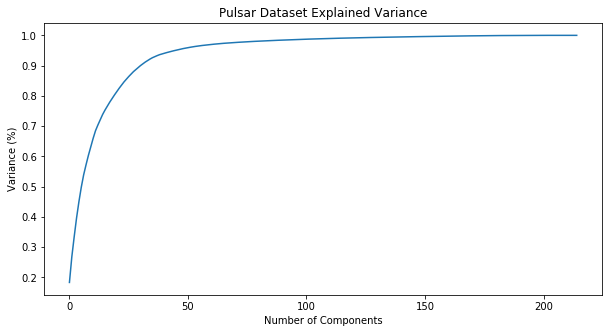

In [117]:
#Fitting the PCA algorithm with our Data
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(train_transformed, )
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [118]:
train_transformed.columns

Index(['age', 'duration', 'product_0_CLS', 'product_0_NAN', 'product_0_UTL',
       'product_1_CLS', 'product_1_NAN', 'product_1_OPN', 'product_1_UTL',
       'product_2_CLS',
       ...
       'job_title_финансовый директор', 'job_title_экономист',
       'job_title_экспедитор', 'job_title_эксперт', 'job_title_электрик',
       'job_title_электрогазосварщик', 'job_title_электромонтажник',
       'job_title_электромонтер', 'job_title_юрисконсульт', 'job_title_юрист'],
      dtype='object', length=215)

## 2) Transactions

Средняя сумма транзакций с нулями и без - done <br>
Кол-во транзакций с нулями и без - done <br>

In [119]:
transactions = aggregate_transactions(DATA_PATH+'transactions.csv')

In [120]:
transactions.head()

,av,av_n_z,num_tr,num_tr_n_z
15,22210.000000,23627.659574,100.0,2221000.0
73,3768.852459,5063.876652,305.0,1149500.0
91,3588.983051,4505.319149,118.0,423500.0
144,1000.000000,1250.000000,5.0,5000.0
150,0.000000,0.000000,4.0,1.0


In [121]:
# with open("../PreprocessedData/transactions", "wb") as fp:
#     pickle.dump(transactions, fp)

## 3) Stories

In [122]:
stories = pd.read_csv(DATA_PATH+'stories_description.csv')

In [123]:
model = FastText.load_fasttext_format('../PretrainedEmbeddings/ft_native_300_ru_wiki_lenta_remstopwords.bin')

In [124]:
REG_TEXT = "text\":\"(.*?)\","
REG_NAME = "name\":\"(.*?)\","
NUM_SWIPES = "description\":\"[0-9]{1,2}"

In [125]:
decoded_stories = dict()
for i in stories.index:
    cur_story = stories['story_json'][i]
    story_info = dict()
    name = re.findall(REG_NAME, cur_story)
    name = "" if len(name) == 0 else clean_sentence(name[0]).split()
    name_n = []
    for w in name:
        if len(w) > 1:
            name_n.append(w)
    story_info['name'] = name_n
    story_info['text'], story_info['n_words'] = clean_text(re.findall(REG_TEXT, cur_story))
    story_info['swipes'] = len(re.findall(NUM_SWIPES, cur_story))
    decoded_stories[stories['story_id'][i]] = story_info

In [126]:
(model.wv['привет'] - np.mean(model.wv['привет'])) / np.std(model.wv['привет'])

array([-1.65821195e+00,  1.31126368e+00,  1.11925006e-01, -6.35337055e-01,
       -7.50740767e-01,  3.37734342e-01, -2.09613276e+00,  1.36840236e+00,
        7.63694286e-01, -4.88340646e-01, -5.61835766e-01, -3.97025704e-01,
        2.76810765e-01,  3.71007800e-01,  1.30063474e+00,  1.02928901e+00,
        1.09104657e+00, -7.88901627e-01,  2.04760599e+00, -3.70487213e-01,
       -2.02876270e-01,  1.23779930e-01, -6.12025082e-01,  9.36453700e-01,
        4.83175188e-01, -1.00241053e+00,  9.64126706e-01,  7.38306418e-02,
       -9.00948703e-01, -7.50917912e-01, -8.50287676e-01, -7.01440990e-01,
       -1.43484962e+00, -1.30830562e+00,  8.12201142e-01, -1.16317105e+00,
       -1.16751134e+00, -2.08505917e+00, -5.40413022e-01,  1.85806251e+00,
       -1.11552924e-01,  6.00020826e-01,  2.48514060e-02,  5.96771836e-01,
       -5.58572292e-01, -7.21455216e-01, -1.71591723e+00, -2.07547927e+00,
        6.71559036e-01,  9.93494749e-01, -1.01905072e+00,  8.30330968e-01,
        5.15706956e-01, -

In [127]:
embedded_stories = dict()
for key in decoded_stories.keys():
    cur_story = decoded_stories[key]
    cur_emb = np.zeros(300)
    for i in range(len(cur_story['text'])):
        try:
            cur_emb += np.average(model.wv[cur_story['text'][i]], axis=0)
        except KeyError:
            continue
    try:
        cur_emb += np.average(model.wv[cur_story['name']], axis=0)
    except:
        pass
    cur_emb = (cur_emb - np.mean(cur_emb)) / (np.std(cur_emb) + 1e-8)
    embedded_stories[key] = {'emb': cur_emb,
                             'n_words': cur_story['n_words'],
                             'swipes' : cur_story['swipes']
                            }

In [128]:
# with open("../PreprocessedData/embedded_stories", "wb") as fp:
#     pickle.dump(embedded_stories, fp)

## 4) Whatching the same stories twice

Смотрел ужк или нет <br>
Сколько раз смотрел на текущий момент

In [129]:
train_y = pd.read_csv(DATA_PATH+'stories_reaction_train.csv')
test_y = pd.read_csv(DATA_PATH+'stories_reaction_test.csv')

In [130]:
train_y.head()

,customer_id,story_id,event_dttm,event
0,15,138,2018-07-24 15:33:22,view
1,15,202,2018-06-04 08:08:08,skip
2,15,222,2018-06-17 13:44:45,skip
3,15,379,2018-05-23 05:41:43,skip
4,15,544,2018-07-25 02:16:29,view


In [131]:
y = pd.concat([train_y.drop(columns='event'), test_y.drop(columns='answer_id')])

In [132]:
y.index = y.customer_id
y = y.drop(columns='customer_id')

,story_id,event_dttm
customer_id,,
15,138,2018-07-24 15:33:22
15,202,2018-06-04 08:08:08
15,222,2018-06-17 13:44:45
15,379,2018-05-23 05:41:43
15,544,2018-07-25 02:16:29


In [135]:
idxs = np.unique(y.index)
customer_views = dict()
for id_c in tqdm.tqdm(idxs):
    cur_y = y.loc[id_c]
    cur_customer_views = dict()
    for story in np.unique(cur_y['story_id']):
        cur_story = dict()
        dates = cur_y[cur_y['story_id'] == story]
        # print(type(dates), story)
        if type(dates) != type('aaa'):
            dates = np.array(dates['event_dttm'])
        else:
            dates = [dates]
        dates = sorted([datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in dates])
        for j in range(len(dates)):
            cur_story[dates[j]] = j
        cur_customer_views[story] = cur_story
    customer_views[id_c] = cur_customer_views

100%|██████████| 49387/49387 [07:20<00:00, 112.09it/s]


In [136]:
with open("../PreprocessedData/customer_views", "wb") as fp:
    pickle.dump(customer_views, fp)

## 5) Aggregating all previous into one dataset

#### Loading previous preprocess

In [28]:
with open("../PreprocessedData/transactions", "rb") as fp:
    transactions = pickle.load(fp)

In [29]:
with open("../PreprocessedData/embedded_stories", "rb") as fp:
    embedded_stories = pickle.load(fp)

In [30]:
with open("../PreprocessedData/customer_views", "rb") as fp:
    customer_views = pickle.load(fp)

In [38]:
train_y = pd.read_csv(DATA_PATH+'stories_reaction_train.csv')
test_y = pd.read_csv(DATA_PATH+'stories_reaction_test.csv')

#### Not all cusomers from trani_y are in transactions, so swap their info to average

In [31]:
av_transaction = list(np.mean(transactions, axis=0))

In [32]:
av_transaction

[1212.4871354047252, 1792.7243260481805, 84.15938911135724, 82035.79185481809]

#### Not all stories from train_y are in stories, so swap their info to average. Maybe we should just drop them from dataset??

In [33]:
embs = np.zeros(300)
words = 0
swipes = 0
num_stories = len(embedded_stories.keys())
for key in embedded_stories.keys():
    embs += embedded_stories[key]['emb']
    words += embedded_stories[key]['n_words']
    swipes += embedded_stories[key]['swipes']

In [34]:
av_story = {'emb': embs / num_stories,
            'n_words': words // num_stories,
            'swipes': swipes // num_stories
           }

#### The same with users. Solution: just drop those users

In [74]:
def final_preprocess(y, train_transformed, bonus, transactions, embedded_stories, customer_views, label_col='event'):
    final_df = []
    final_labels = []
    for i in tqdm.tqdm(range(len(y))):
        row = []
        cur_view = y.iloc[i]

        cus_id = cur_view['customer_id']
        try:
            row += list(train_transformed.loc[cus_id])
        except KeyError:
            try:
                row += list(bonus.loc[cus_id])
            except KeyError:
                continue
        try:
            row += list(transactions.loc[cus_id])
        except KeyError:
            row += av_transaction

        story_id = cur_view['story_id']
        try:
            story = embedded_stories[story_id]
        except KeyError:
            story = av_story
        row += [story['n_words']]
        row += [story['swipes']]
        row += list(story['emb'])

        view_date = datetime.strptime(cur_view['event_dttm'], '%Y-%m-%d %H:%M:%S')
        num_prev = customer_views[cus_id][story_id][view_date]
        if num_prev:
            row += [num_prev, 1]
        else:
            row += [num_prev, 0]
        final_df.append(row)
        final_labels.append(cur_view[label_col])
        
    return final_df, final_labels

In [75]:
train = train_transformed.iloc[0: train.shape[0]]
test = train_transformed.iloc[train.shape[0]: ]

In [76]:
train_fin, train_label_fin = final_preprocess(train_y, train, test, transactions, embedded_stories,
                                              customer_views, label_col='event')





  0%|          | 0/473141 [00:00<?, ?it/s]



  0%|          | 149/473141 [00:00<05:17, 1487.49it/s]



  0%|          | 298/473141 [00:00<05:17, 1487.68it/s]



  0%|          | 456/473141 [00:00<05:12, 1513.41it/s]



  0%|          | 608/473141 [00:00<05:11, 1515.37it/s]



  0%|          | 760/473141 [00:00<05:11, 1514.74it/s]



  0%|          | 909/473141 [00:00<05:13, 1506.08it/s]



  0%|          | 1060/473141 [00:00<05:13, 1506.37it/s]



  0%|          | 1213/473141 [00:00<05:11, 1512.97it/s]



  0%|          | 1360/473141 [00:00<05:14, 1499.12it/s]



  0%|          | 1510/473141 [00:01<05:14, 1498.20it/s]



  0%|          | 1656/473141 [00:01<05:18, 1482.27it/s]



  0%|          | 1808/473141 [00:01<05:16, 1490.35it/s]



  0%|          | 1960/473141 [00:01<05:14, 1496.21it/s]



  0%|          | 2109/473141 [00:01<05:17, 1482.66it/s]



  0%|          | 2265/473141 [00:01<05:13, 1504.27it/s]



  1%|          | 2417/473141 [00:01<05:12, 1506.40it/s]



  1%|       

  7%|▋         | 34120/473141 [00:23<04:51, 1504.00it/s]



  7%|▋         | 34271/473141 [00:23<04:55, 1485.65it/s]



  7%|▋         | 34420/473141 [00:23<05:07, 1426.08it/s]



  7%|▋         | 34568/473141 [00:23<05:04, 1440.37it/s]



  7%|▋         | 34718/473141 [00:23<05:01, 1455.09it/s]



  7%|▋         | 34867/473141 [00:23<04:59, 1463.45it/s]



  7%|▋         | 35014/473141 [00:23<04:59, 1462.08it/s]



  7%|▋         | 35161/473141 [00:23<05:02, 1449.96it/s]



  7%|▋         | 35311/473141 [00:23<04:59, 1461.98it/s]



  7%|▋         | 35461/473141 [00:23<04:57, 1470.75it/s]



  8%|▊         | 35609/473141 [00:24<05:00, 1457.28it/s]



  8%|▊         | 35758/473141 [00:24<04:58, 1466.34it/s]



  8%|▊         | 35908/473141 [00:24<04:56, 1474.59it/s]



  8%|▊         | 36059/473141 [00:24<04:54, 1482.81it/s]



  8%|▊         | 36210/473141 [00:24<04:53, 1489.96it/s]



  8%|▊         | 36360/473141 [00:24<04:53, 1487.45it/s]



  8%|▊         | 36513/473141 [00:24<04:

 14%|█▍        | 67996/473141 [00:50<04:33, 1483.95it/s]



 14%|█▍        | 68149/473141 [00:50<04:30, 1496.90it/s]



 14%|█▍        | 68299/473141 [00:50<04:30, 1496.70it/s]



 14%|█▍        | 68449/473141 [00:50<04:33, 1481.96it/s]



 14%|█▍        | 68599/473141 [00:50<04:32, 1487.25it/s]



 15%|█▍        | 68748/473141 [00:50<04:32, 1486.20it/s]



 15%|█▍        | 68902/473141 [00:50<04:29, 1500.27it/s]



 15%|█▍        | 69056/473141 [00:50<04:27, 1509.82it/s]



 15%|█▍        | 69208/473141 [00:51<04:30, 1490.74it/s]



 15%|█▍        | 69358/473141 [00:51<04:35, 1467.84it/s]



 15%|█▍        | 69507/473141 [00:51<04:33, 1473.63it/s]



 15%|█▍        | 69657/473141 [00:51<04:32, 1480.47it/s]



 15%|█▍        | 69806/473141 [00:51<04:34, 1471.58it/s]



 15%|█▍        | 69956/473141 [00:51<04:32, 1478.94it/s]



 15%|█▍        | 70107/473141 [00:51<04:31, 1486.20it/s]



 15%|█▍        | 70257/473141 [00:51<04:30, 1488.44it/s]



 15%|█▍        | 70408/473141 [00:51<04:

 22%|██▏       | 101813/473141 [01:13<04:07, 1501.85it/s]



 22%|██▏       | 101965/473141 [01:13<04:06, 1505.16it/s]



 22%|██▏       | 102116/473141 [01:13<04:07, 1497.90it/s]



 22%|██▏       | 102268/473141 [01:13<04:06, 1502.78it/s]



 22%|██▏       | 102419/473141 [01:13<04:06, 1504.39it/s]



 22%|██▏       | 102572/473141 [01:13<04:05, 1510.62it/s]



 22%|██▏       | 102724/473141 [01:13<04:07, 1495.17it/s]



 22%|██▏       | 102875/473141 [01:13<04:07, 1496.27it/s]



 22%|██▏       | 103027/473141 [01:14<04:06, 1501.82it/s]



 22%|██▏       | 103180/473141 [01:14<04:05, 1508.04it/s]



 22%|██▏       | 103331/473141 [01:14<04:07, 1496.74it/s]



 22%|██▏       | 103481/473141 [01:14<04:10, 1476.25it/s]



 22%|██▏       | 103633/473141 [01:14<04:08, 1488.60it/s]



 22%|██▏       | 103785/473141 [01:14<04:06, 1497.17it/s]



 22%|██▏       | 103937/473141 [01:14<04:05, 1501.44it/s]



 22%|██▏       | 104090/473141 [01:14<04:04, 1506.84it/s]



 22%|██▏       | 104241/

 29%|██▊       | 135711/473141 [01:36<03:44, 1505.99it/s]



 29%|██▊       | 135862/473141 [01:36<03:45, 1498.25it/s]



 29%|██▊       | 136015/473141 [01:36<03:44, 1505.02it/s]



 29%|██▉       | 136166/473141 [01:36<03:49, 1466.15it/s]



 29%|██▉       | 136315/473141 [01:36<03:48, 1472.23it/s]



 29%|██▉       | 136463/473141 [01:36<03:49, 1469.14it/s]



 29%|██▉       | 136614/473141 [01:36<03:47, 1478.75it/s]



 29%|██▉       | 136762/473141 [01:36<03:51, 1451.15it/s]



 29%|██▉       | 136917/473141 [01:36<03:47, 1479.44it/s]



 29%|██▉       | 137071/473141 [01:37<03:44, 1495.56it/s]



 29%|██▉       | 137221/473141 [01:37<03:44, 1494.74it/s]



 29%|██▉       | 137375/473141 [01:37<03:42, 1505.94it/s]



 29%|██▉       | 137529/473141 [01:37<03:41, 1514.13it/s]



 29%|██▉       | 137684/473141 [01:37<03:40, 1522.73it/s]



 29%|██▉       | 137839/473141 [01:37<03:57, 1408.94it/s]



 29%|██▉       | 137996/473141 [01:37<03:50, 1453.02it/s]



 29%|██▉       | 138151/

 36%|███▌      | 169411/473141 [01:58<03:24, 1488.67it/s]



 36%|███▌      | 169560/473141 [01:59<03:24, 1482.26it/s]



 36%|███▌      | 169709/473141 [01:59<03:27, 1463.04it/s]



 36%|███▌      | 169861/473141 [01:59<03:25, 1477.25it/s]



 36%|███▌      | 170014/473141 [01:59<03:23, 1491.49it/s]



 36%|███▌      | 170164/473141 [01:59<03:24, 1483.12it/s]



 36%|███▌      | 170313/473141 [01:59<03:24, 1478.47it/s]



 36%|███▌      | 170461/473141 [01:59<03:25, 1475.34it/s]



 36%|███▌      | 170611/473141 [01:59<03:24, 1480.20it/s]



 36%|███▌      | 170761/473141 [01:59<03:23, 1485.88it/s]



 36%|███▌      | 170910/473141 [01:59<03:41, 1365.87it/s]



 36%|███▌      | 171061/473141 [02:00<03:35, 1404.50it/s]



 36%|███▌      | 171211/473141 [02:00<03:30, 1431.25it/s]



 36%|███▌      | 171361/473141 [02:00<03:28, 1449.26it/s]



 36%|███▌      | 171507/473141 [02:00<03:27, 1450.59it/s]



 36%|███▋      | 171657/473141 [02:00<03:25, 1465.01it/s]



 36%|███▋      | 171807/

 43%|████▎     | 203186/473141 [02:21<03:02, 1478.70it/s]



 43%|████▎     | 203336/473141 [02:21<03:01, 1482.86it/s]



 43%|████▎     | 203487/473141 [02:21<03:00, 1490.41it/s]



 43%|████▎     | 203638/473141 [02:21<03:00, 1495.41it/s]



 43%|████▎     | 203789/473141 [02:22<02:59, 1497.76it/s]



 43%|████▎     | 203939/473141 [02:22<03:14, 1385.89it/s]



 43%|████▎     | 204087/473141 [02:22<03:10, 1412.25it/s]



 43%|████▎     | 204237/473141 [02:22<03:07, 1434.48it/s]



 43%|████▎     | 204388/473141 [02:22<03:04, 1456.04it/s]



 43%|████▎     | 204535/473141 [02:22<03:04, 1459.19it/s]



 43%|████▎     | 204684/473141 [02:22<03:02, 1467.10it/s]



 43%|████▎     | 204834/473141 [02:22<03:01, 1474.62it/s]



 43%|████▎     | 204982/473141 [02:22<03:02, 1466.46it/s]



 43%|████▎     | 205129/473141 [02:23<03:02, 1465.71it/s]



 43%|████▎     | 205276/473141 [02:23<03:04, 1454.53it/s]



 43%|████▎     | 205433/473141 [02:23<03:00, 1485.39it/s]



 43%|████▎     | 205594/

 50%|█████     | 236741/473141 [02:44<02:40, 1474.20it/s]



 50%|█████     | 236889/473141 [02:44<02:57, 1331.61it/s]



 50%|█████     | 237039/473141 [02:44<02:51, 1375.43it/s]



 50%|█████     | 237188/473141 [02:44<02:47, 1406.59it/s]



 50%|█████     | 237337/473141 [02:44<02:44, 1430.14it/s]



 50%|█████     | 237482/473141 [02:45<02:45, 1426.84it/s]



 50%|█████     | 237628/473141 [02:45<02:44, 1436.05it/s]



 50%|█████     | 237777/473141 [02:45<02:42, 1450.95it/s]



 50%|█████     | 237928/473141 [02:45<02:40, 1467.25it/s]



 50%|█████     | 238080/473141 [02:45<02:38, 1482.23it/s]



 50%|█████     | 238229/473141 [02:45<02:39, 1475.84it/s]



 50%|█████     | 238379/473141 [02:45<02:38, 1482.17it/s]



 50%|█████     | 238532/473141 [02:45<02:36, 1494.70it/s]



 50%|█████     | 238682/473141 [02:45<02:37, 1492.73it/s]



 50%|█████     | 238832/473141 [02:45<02:37, 1491.23it/s]



 51%|█████     | 238982/473141 [02:46<02:39, 1472.35it/s]



 51%|█████     | 239130/

 57%|█████▋    | 270379/473141 [03:07<02:18, 1465.46it/s]



 57%|█████▋    | 270527/473141 [03:07<02:24, 1406.14it/s]



 57%|█████▋    | 270678/473141 [03:07<02:21, 1435.41it/s]



 57%|█████▋    | 270829/473141 [03:07<02:19, 1455.25it/s]



 57%|█████▋    | 270980/473141 [03:07<02:17, 1471.22it/s]



 57%|█████▋    | 271128/473141 [03:07<02:17, 1466.16it/s]



 57%|█████▋    | 271278/473141 [03:07<02:16, 1476.07it/s]



 57%|█████▋    | 271428/473141 [03:08<02:16, 1479.95it/s]



 57%|█████▋    | 271578/473141 [03:08<02:15, 1483.05it/s]



 57%|█████▋    | 271727/473141 [03:08<02:17, 1466.26it/s]



 57%|█████▋    | 271874/473141 [03:08<02:17, 1460.74it/s]



 57%|█████▋    | 272024/473141 [03:08<02:16, 1470.64it/s]



 58%|█████▊    | 272174/473141 [03:08<02:16, 1477.17it/s]



 58%|█████▊    | 272326/473141 [03:08<02:15, 1486.27it/s]



 58%|█████▊    | 272475/473141 [03:08<02:15, 1485.41it/s]



 58%|█████▊    | 272626/473141 [03:08<02:14, 1492.68it/s]



 58%|█████▊    | 272777/

 64%|██████▍   | 304017/473141 [03:30<01:50, 1527.65it/s]



 64%|██████▍   | 304171/473141 [03:30<01:51, 1509.69it/s]



 64%|██████▍   | 304324/473141 [03:30<01:51, 1513.87it/s]



 64%|██████▍   | 304476/473141 [03:30<01:51, 1510.55it/s]



 64%|██████▍   | 304628/473141 [03:30<01:51, 1505.55it/s]



 64%|██████▍   | 304779/473141 [03:30<01:53, 1488.46it/s]



 64%|██████▍   | 304929/473141 [03:30<01:53, 1488.25it/s]



 64%|██████▍   | 305079/473141 [03:30<01:52, 1490.24it/s]



 65%|██████▍   | 305229/473141 [03:30<01:52, 1490.84it/s]



 65%|██████▍   | 305379/473141 [03:31<01:52, 1485.63it/s]



 65%|██████▍   | 305528/473141 [03:31<01:53, 1479.51it/s]



 65%|██████▍   | 305679/473141 [03:31<01:52, 1487.01it/s]



 65%|██████▍   | 305828/473141 [03:31<01:52, 1487.79it/s]



 65%|██████▍   | 305979/473141 [03:31<01:52, 1491.90it/s]



 65%|██████▍   | 306129/473141 [03:31<01:52, 1479.78it/s]



 65%|██████▍   | 306278/473141 [03:31<01:52, 1482.74it/s]



 65%|██████▍   | 306428/

 71%|███████▏  | 337819/473141 [03:52<01:28, 1524.53it/s]



 71%|███████▏  | 337972/473141 [03:52<01:29, 1509.89it/s]



 71%|███████▏  | 338124/473141 [03:53<01:29, 1504.65it/s]



 71%|███████▏  | 338279/473141 [03:53<01:28, 1516.61it/s]



 72%|███████▏  | 338431/473141 [03:53<01:29, 1511.57it/s]



 72%|███████▏  | 338584/473141 [03:53<01:28, 1516.03it/s]



 72%|███████▏  | 338737/473141 [03:53<01:28, 1519.27it/s]



 72%|███████▏  | 338892/473141 [03:53<01:27, 1526.14it/s]



 72%|███████▏  | 339045/473141 [03:53<01:28, 1513.16it/s]



 72%|███████▏  | 339197/473141 [03:53<01:30, 1472.93it/s]



 72%|███████▏  | 339345/473141 [03:53<01:31, 1463.19it/s]



 72%|███████▏  | 339496/473141 [03:54<01:30, 1474.67it/s]



 72%|███████▏  | 339646/473141 [03:54<01:30, 1481.05it/s]



 72%|███████▏  | 339795/473141 [03:54<01:30, 1471.12it/s]



 72%|███████▏  | 339946/473141 [03:54<01:29, 1480.65it/s]



 72%|███████▏  | 340096/473141 [03:54<01:29, 1483.83it/s]



 72%|███████▏  | 340245/

 79%|███████▊  | 371530/473141 [04:15<01:08, 1479.96it/s]



 79%|███████▊  | 371681/473141 [04:15<01:08, 1487.45it/s]



 79%|███████▊  | 371830/473141 [04:15<01:08, 1486.47it/s]



 79%|███████▊  | 371979/473141 [04:15<01:08, 1486.82it/s]



 79%|███████▊  | 372130/473141 [04:16<01:07, 1492.41it/s]



 79%|███████▊  | 372284/473141 [04:16<01:06, 1505.63it/s]



 79%|███████▊  | 372435/473141 [04:16<01:06, 1505.76it/s]



 79%|███████▊  | 372586/473141 [04:16<01:06, 1506.04it/s]



 79%|███████▉  | 372737/473141 [04:16<01:07, 1492.25it/s]



 79%|███████▉  | 372889/473141 [04:16<01:06, 1497.62it/s]



 79%|███████▉  | 373040/473141 [04:16<01:06, 1498.82it/s]



 79%|███████▉  | 373192/473141 [04:16<01:06, 1502.32it/s]



 79%|███████▉  | 373343/473141 [04:16<01:06, 1500.19it/s]



 79%|███████▉  | 373494/473141 [04:16<01:07, 1485.62it/s]



 79%|███████▉  | 373644/473141 [04:17<01:06, 1487.68it/s]



 79%|███████▉  | 373794/473141 [04:17<01:06, 1490.81it/s]



 79%|███████▉  | 373944/

 86%|████████▌ | 405180/473141 [04:38<00:45, 1492.20it/s]



 86%|████████▌ | 405330/473141 [04:38<00:45, 1480.39it/s]



 86%|████████▌ | 405479/473141 [04:38<00:46, 1461.36it/s]



 86%|████████▌ | 405626/473141 [04:38<00:46, 1457.60it/s]



 86%|████████▌ | 405772/473141 [04:38<00:46, 1456.05it/s]



 86%|████████▌ | 405922/473141 [04:39<00:45, 1468.75it/s]



 86%|████████▌ | 406072/473141 [04:39<00:45, 1477.45it/s]



 86%|████████▌ | 406221/473141 [04:39<00:45, 1479.34it/s]



 86%|████████▌ | 406374/473141 [04:39<00:44, 1492.08it/s]



 86%|████████▌ | 406524/473141 [04:39<00:45, 1458.70it/s]



 86%|████████▌ | 406674/473141 [04:39<00:45, 1469.82it/s]



 86%|████████▌ | 406824/473141 [04:39<00:44, 1477.15it/s]



 86%|████████▌ | 406974/473141 [04:39<00:44, 1483.85it/s]



 86%|████████▌ | 407123/473141 [04:39<00:44, 1473.72it/s]



 86%|████████▌ | 407277/473141 [04:39<00:44, 1491.86it/s]



 86%|████████▌ | 407427/473141 [04:40<00:44, 1492.22it/s]



 86%|████████▌ | 407577/

 93%|█████████▎| 438987/473141 [05:01<00:23, 1476.14it/s]



 93%|█████████▎| 439138/473141 [05:01<00:22, 1484.79it/s]



 93%|█████████▎| 439289/473141 [05:01<00:22, 1490.27it/s]



 93%|█████████▎| 439439/473141 [05:01<00:22, 1475.58it/s]



 93%|█████████▎| 439591/473141 [05:01<00:22, 1486.47it/s]



 93%|█████████▎| 439743/473141 [05:01<00:22, 1494.20it/s]



 93%|█████████▎| 439893/473141 [05:01<00:22, 1494.82it/s]



 93%|█████████▎| 440043/473141 [05:02<00:22, 1477.40it/s]



 93%|█████████▎| 440193/473141 [05:02<00:22, 1481.82it/s]



 93%|█████████▎| 440343/473141 [05:02<00:22, 1485.38it/s]



 93%|█████████▎| 440493/473141 [05:02<00:21, 1487.70it/s]



 93%|█████████▎| 440644/473141 [05:02<00:21, 1492.75it/s]



 93%|█████████▎| 440794/473141 [05:02<00:21, 1480.40it/s]



 93%|█████████▎| 440943/473141 [05:02<00:21, 1482.15it/s]



 93%|█████████▎| 441093/473141 [05:02<00:21, 1486.37it/s]



 93%|█████████▎| 441245/473141 [05:02<00:21, 1496.23it/s]



 93%|█████████▎| 441399/

100%|█████████▉| 472689/473141 [05:29<00:00, 1440.48it/s]



100%|█████████▉| 472835/473141 [05:29<00:00, 1443.99it/s]



100%|█████████▉| 472980/473141 [05:29<00:00, 1439.49it/s]



100%|█████████▉| 473128/473141 [05:29<00:00, 1451.37it/s]



100%|██████████| 473141/473141 [05:30<00:00, 1433.75it/s]

In [77]:
test_fin, test_label_fin = final_preprocess(test_y, test, train, transactions, embedded_stories,
                                            customer_views, label_col='answer_id')





  0%|          | 0/172049 [00:00<?, ?it/s]



  0%|          | 147/172049 [00:00<01:57, 1462.91it/s]



  0%|          | 295/172049 [00:00<01:57, 1466.71it/s]



  0%|          | 439/172049 [00:00<01:57, 1457.33it/s]



  0%|          | 577/172049 [00:00<01:59, 1432.18it/s]



  0%|          | 726/172049 [00:00<01:58, 1447.32it/s]



  1%|          | 874/172049 [00:00<01:57, 1455.56it/s]



  1%|          | 1023/172049 [00:00<01:56, 1464.44it/s]



  1%|          | 1172/172049 [00:00<01:56, 1470.78it/s]



  1%|          | 1316/172049 [00:00<01:56, 1460.88it/s]



  1%|          | 1465/172049 [00:01<01:56, 1467.60it/s]



  1%|          | 1613/172049 [00:01<01:55, 1470.59it/s]



  1%|          | 1763/172049 [00:01<01:55, 1477.94it/s]



  1%|          | 1909/172049 [00:01<01:56, 1464.06it/s]



  1%|          | 2058/172049 [00:01<01:55, 1471.73it/s]



  1%|▏         | 2206/172049 [00:01<01:55, 1472.85it/s]



  1%|▏         | 2355/172049 [00:01<01:54, 1477.58it/s]



  1%|▏      

 20%|█▉        | 33948/172049 [00:23<01:33, 1469.28it/s]



 20%|█▉        | 34095/172049 [00:23<01:33, 1467.82it/s]



 20%|█▉        | 34242/172049 [00:23<01:33, 1468.23it/s]



 20%|█▉        | 34389/172049 [00:23<01:34, 1458.74it/s]



 20%|██        | 34539/172049 [00:23<01:33, 1470.16it/s]



 20%|██        | 34688/172049 [00:23<01:33, 1473.46it/s]



 20%|██        | 34838/172049 [00:23<01:32, 1479.85it/s]



 20%|██        | 34987/172049 [00:23<01:33, 1467.88it/s]



 20%|██        | 35134/172049 [00:23<01:33, 1467.55it/s]



 21%|██        | 35281/172049 [00:23<01:33, 1467.40it/s]



 21%|██        | 35431/172049 [00:24<01:32, 1475.51it/s]



 21%|██        | 35579/172049 [00:24<01:32, 1472.63it/s]



 21%|██        | 35727/172049 [00:24<01:33, 1456.47it/s]



 21%|██        | 35874/172049 [00:24<01:33, 1459.35it/s]



 21%|██        | 36021/172049 [00:24<01:33, 1460.47it/s]



 21%|██        | 36169/172049 [00:24<01:32, 1464.23it/s]



 21%|██        | 36316/172049 [00:24<01:

 39%|███▉      | 67659/172049 [00:46<01:09, 1506.30it/s]



 39%|███▉      | 67812/172049 [00:46<01:08, 1512.50it/s]



 40%|███▉      | 67964/172049 [00:46<01:08, 1508.80it/s]



 40%|███▉      | 68115/172049 [00:46<01:09, 1493.60it/s]



 40%|███▉      | 68266/172049 [00:46<01:09, 1495.65it/s]



 40%|███▉      | 68416/172049 [00:46<01:09, 1493.81it/s]



 40%|███▉      | 68569/172049 [00:46<01:08, 1501.92it/s]



 40%|███▉      | 68720/172049 [00:46<01:09, 1494.53it/s]



 40%|████      | 68870/172049 [00:46<01:09, 1493.56it/s]



 40%|████      | 69022/172049 [00:46<01:08, 1500.30it/s]



 40%|████      | 69177/172049 [00:47<01:07, 1514.15it/s]



 40%|████      | 69333/172049 [00:47<01:07, 1525.79it/s]



 40%|████      | 69486/172049 [00:47<01:12, 1407.86it/s]



 40%|████      | 69640/172049 [00:47<01:10, 1443.71it/s]



 41%|████      | 69795/172049 [00:47<01:09, 1471.91it/s]



 41%|████      | 69947/172049 [00:47<01:08, 1485.19it/s]



 41%|████      | 70099/172049 [00:47<01:

 59%|█████▉    | 101934/172049 [01:09<00:47, 1486.83it/s]



 59%|█████▉    | 102083/172049 [01:09<00:52, 1331.07it/s]



 59%|█████▉    | 102233/172049 [01:09<00:50, 1375.85it/s]



 60%|█████▉    | 102384/172049 [01:09<00:49, 1411.82it/s]



 60%|█████▉    | 102528/172049 [01:09<00:53, 1305.11it/s]



 60%|█████▉    | 102677/172049 [01:09<00:51, 1354.72it/s]



 60%|█████▉    | 102826/172049 [01:09<00:49, 1392.09it/s]



 60%|█████▉    | 102978/172049 [01:09<00:48, 1425.67it/s]



 60%|█████▉    | 103123/172049 [01:09<00:48, 1420.66it/s]



 60%|██████    | 103273/172049 [01:09<00:47, 1441.18it/s]



 60%|██████    | 103426/172049 [01:10<00:46, 1463.38it/s]



 60%|██████    | 103579/172049 [01:10<00:46, 1481.77it/s]



 60%|██████    | 103731/172049 [01:10<00:45, 1491.64it/s]



 60%|██████    | 103881/172049 [01:10<00:45, 1484.45it/s]



 60%|██████    | 104033/172049 [01:10<00:45, 1491.75it/s]



 61%|██████    | 104186/172049 [01:10<00:45, 1502.02it/s]



 61%|██████    | 104337/

 79%|███████▉  | 135501/172049 [01:31<00:26, 1386.51it/s]



 79%|███████▉  | 135652/172049 [01:31<00:25, 1420.64it/s]



 79%|███████▉  | 135804/172049 [01:32<00:25, 1447.70it/s]



 79%|███████▉  | 135955/172049 [01:32<00:24, 1463.68it/s]



 79%|███████▉  | 136104/172049 [01:32<00:24, 1470.63it/s]



 79%|███████▉  | 136252/172049 [01:32<00:24, 1461.20it/s]



 79%|███████▉  | 136403/172049 [01:32<00:24, 1473.13it/s]



 79%|███████▉  | 136553/172049 [01:32<00:23, 1480.60it/s]



 79%|███████▉  | 136702/172049 [01:32<00:23, 1478.45it/s]



 80%|███████▉  | 136851/172049 [01:32<00:23, 1472.32it/s]



 80%|███████▉  | 137001/172049 [01:32<00:23, 1478.11it/s]



 80%|███████▉  | 137150/172049 [01:32<00:23, 1480.64it/s]



 80%|███████▉  | 137299/172049 [01:33<00:23, 1480.25it/s]



 80%|███████▉  | 137448/172049 [01:33<00:23, 1482.15it/s]



 80%|███████▉  | 137597/172049 [01:33<00:23, 1470.04it/s]



 80%|████████  | 137746/172049 [01:33<00:23, 1475.34it/s]



 80%|████████  | 137897/

 98%|█████████▊| 169002/172049 [01:54<00:02, 1442.24it/s]



 98%|█████████▊| 169152/172049 [01:54<00:01, 1458.04it/s]



 98%|█████████▊| 169299/172049 [01:54<00:01, 1459.44it/s]



 98%|█████████▊| 169452/172049 [01:54<00:01, 1478.28it/s]



 99%|█████████▊| 169604/172049 [01:54<00:01, 1489.08it/s]



 99%|█████████▊| 169759/172049 [01:55<00:01, 1505.73it/s]



 99%|█████████▉| 169910/172049 [01:55<00:01, 1493.50it/s]



 99%|█████████▉| 170061/172049 [01:55<00:01, 1497.11it/s]



 99%|█████████▉| 170211/172049 [01:55<00:01, 1496.06it/s]



 99%|█████████▉| 170361/172049 [01:55<00:01, 1495.34it/s]



 99%|█████████▉| 170511/172049 [01:55<00:01, 1490.53it/s]



 99%|█████████▉| 170661/172049 [01:55<00:00, 1478.13it/s]



 99%|█████████▉| 170810/172049 [01:55<00:00, 1480.17it/s]



 99%|█████████▉| 170959/172049 [01:55<00:00, 1481.72it/s]



 99%|█████████▉| 171108/172049 [01:56<00:00, 1480.75it/s]



100%|█████████▉| 171257/172049 [01:56<00:00, 1473.05it/s]



100%|█████████▉| 171407/

In [78]:
np.array(test_fin).shape

(172049, 523)

In [79]:
test_y.shape

(172049, 4)

In [80]:
np.array(train_fin).shape

(473141, 523)

In [81]:
train_y.shape

(473141, 4)

In [83]:
del(embedded_stories)
del(transactions)
del(customer_views)
del(train_transformed)
del(train)
del(test)
gc.collect()

432191

In [86]:
np.save("../PreprocessedData/FinalDataset/train_data", np.array(train_fin))
np.save("../PreprocessedData/FinalDataset/train_labels", np.array(train_label_fin))
np.save("../PreprocessedData/FinalDataset/test_data", np.array(test_fin))
np.save("../PreprocessedData/FinalDataset/test_labels", np.array(test_label_fin))

In [87]:
# with open("../PreprocessedData/FinalDataset/train_data", "wb") as fp:
#     pickle.dump(train_fin, fp)

In [ ]:
final_labels = np.array(train_label_fin)
with open("../PreprocessedData/FinalDataset/train_labels", "wb") as fp:
    pickle.dump(final_labels, fp)

In [ ]:
with open("../PreprocessedData/FinalDataset/test_data", "wb") as fp:
    pickle.dump(test_fin, fp)

In [ ]:
final_labels = np.array(test_label_fin)
with open("../PreprocessedData/FinalDataset/test_labels", "wb") as fp:
    pickle.dump(final_labels, fp)

# проверить, может быть эта информация есть в датаесеете test